In [1]:
from get_vibration_data import get_vibration_data
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from fem_model import MeshGNN_GAT2
from tqdm import tqdm
import json
from utils import draw_disp_on_mesh,draw_mesh,inverse_minmax_scale
import pandas as pd
from fem_dataset import FemGraphInferenceDataset
import numpy as np
import matplotlib.pyplot as plt


In [2]:
sample_num=0
Lx=6.025315030989757
Ly=1.0148902056650992
Lz=5.02367346374058
nx=16
ny=18
nz=10
xm0  = 0.9972
xm1= xm0+Lx/nx*2
ym0= 0.36
ym1 = ym0+Ly/ny*2
zm0= 0
zm1 = zm0+Lz/nz*2
E =6.9e10
nu = 0.33
rho = 2700
m_add=31
freq=262
a_base=15
zeta= 0.005



In [3]:
xyz,disp,df_cells,FRF=get_vibration_data(sample_num,Lx,Ly,Lz,nx,ny,nz,xm0,xm1,ym0,ym1,zm0,zm1,E,nu,rho,m_add,freq,a_base,zeta)

Number of converged eigenpairs 645
saved: nodal_stress_disp.csv
saved: edge_infos.csv
saved: params.txt


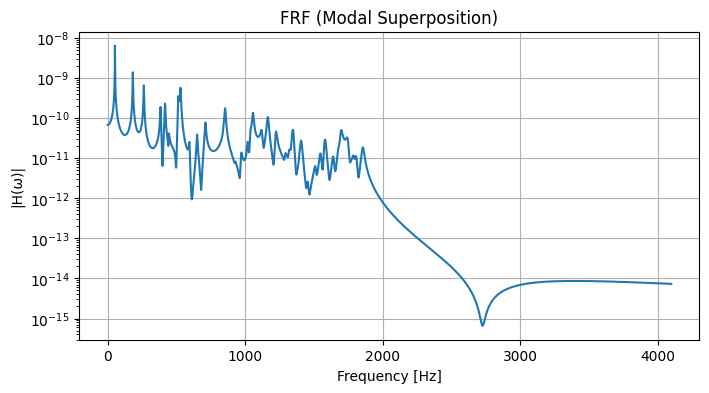

In [4]:
plt.figure(figsize=(8,4))
plt.semilogy(FRF[0], FRF[1])
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(ω)|")
plt.title("FRF (Modal Superposition)")
plt.grid(True)
plt.show()

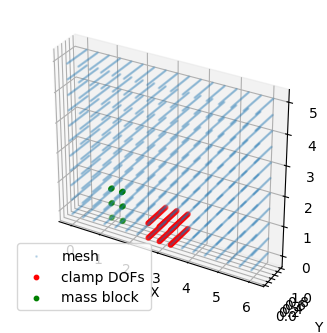

In [5]:
draw_mesh(xyz.values[:,0],xyz.values[:,1],xyz.values[:,2],Lx,Ly,Lz,nx,ny,nz,xm0,xm1,ym0,ym1,zm0,zm1)

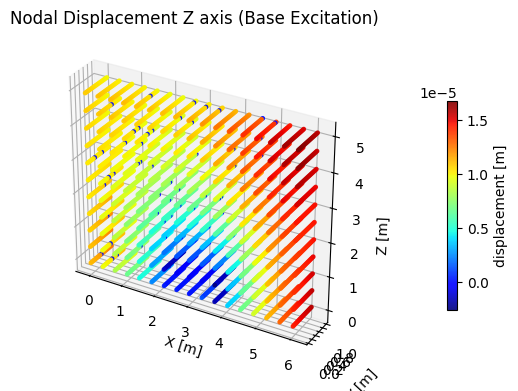

In [6]:
draw_disp_on_mesh(xyz.values[:,0],xyz.values[:,1],xyz.values[:,2],disp.values[:,2])

In [7]:
root = "./test"
if torch.cuda.is_available() :
    device='cuda'
elif torch.backends.mps.is_available() :
    device='mps'
else :
    device='cpu'
file_name="gat2_early"
with open(f"model_param_{file_name}.json", "r", encoding="utf-8") as f:
    model_param = json.load(f)

ds = FemGraphInferenceDataset(root_dir=root,scale_info=model_param['dataset_scale_info'], knn_k=12, use_cell_edges=True)
loader = DataLoader(ds, batch_size=32, shuffle=False)
model = MeshGNN_GAT2(in_dim=model_param['in_dim'],
            edge_dim=model_param['edge_dim'],
            hidden=model_param['hidden'],
            layers=model_param['layers'],
            heads=model_param['head'],
            out_dim=model_param['out_dim'],
            dropout=model_param['dropout']).to(device)

checkpoint = torch.load(f"mesh_invariant_{file_name}.pt", map_location=device)
model.load_state_dict(checkpoint)
model.eval()
for batch in loader:
    batch = batch.to(device)
    pred = model(batch)
    pos=batch.pos.to('cpu').detach().numpy()
    pred=pred.to('cpu').detach().numpy()
    data=np.hstack((pos,pred))
    data=pd.DataFrame(data,columns=["x","y","z","ux","uy","uz"])
    for col in data.columns:
        data[col]=inverse_minmax_scale(data[col].values,model_param['dataset_scale_info'][col]['min'],model_param['dataset_scale_info'][col]['max'])
    break

Loading FEM graph dataset...


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Build Complete FEM graph dataset...


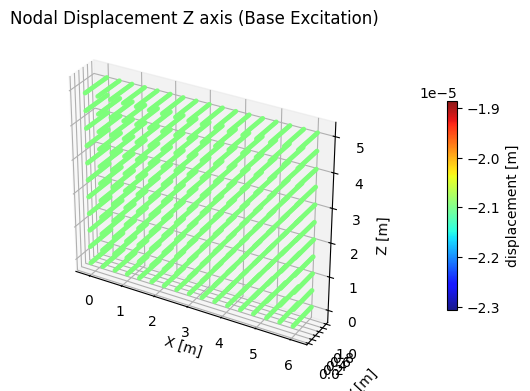

In [8]:
draw_disp_on_mesh(data[['x']].values[:,0],data[['y']].values[:,0],data[['z']].values[:,0],data[['uz']].values[:,0])

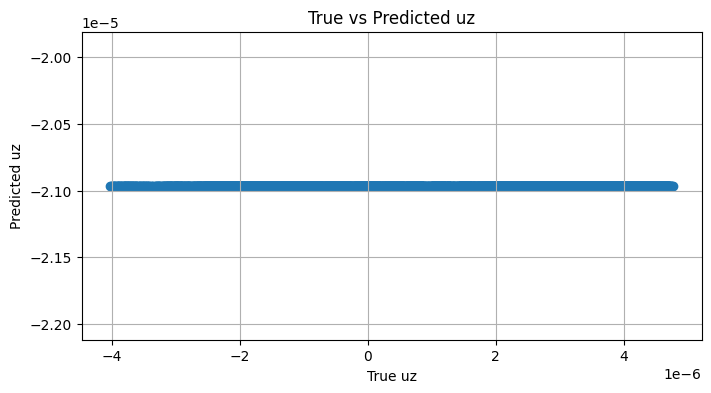

In [9]:
plt.figure(figsize=(8,4))
plt.scatter(disp[['ux']].values.reshape(-1),data[['uz']].values.reshape(-1))
plt.xlabel("True uz")
plt.ylabel("Predicted uz")
plt.title("True vs Predicted uz")
plt.grid(True)
plt.show()